In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from google.colab import drive

import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import seaborn as sn

In [ ]:
# ดึงข้อมูลภาพจาก Google Drive
drive.mount('/content/drive')
train_dir = '/content/drive/My Drive/Jellyfish/Train'
test_dir = '/content/drive/My Drive/Jellyfish/Test'

Mounted at /content/drive


In [ ]:
# สร้าง train และ test set
# train_datagen = ImageDataGenerator(rescale=1./255)

# สร้าง train set และมีการทำ Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,               # การปรับขนาด เพื่อแปลงค่า pixel ช่วง 0-255 ไปเป็น 0-1
    rotation_range=20,            # หมุนภาพสุ่มไม่เกิน 20 องศา
    width_shift_range=0.2,        # เลื่อนภาพในแนวนอนสุ่มไม่เกิน 20%
    height_shift_range=0.2,       # เลื่อนภาพในแนวตั้งสุ่มไม่เกิน 20%
    shear_range=0.2,              # ใช้ shear transformation
    zoom_range=0.2,               # ซูมภาพแบบสุ่ม
    horizontal_flip=True,         # พลิกภาพในแนวนอนแบบสุ่ม
    brightness_range=[0.8,1.2],   # ปรับระดับความสว่าง
    fill_mode='nearest'           # เติมช่องว่างด้วยวิธี nearest
)

test_datagen = ImageDataGenerator(rescale=1./255)

# โหลดภาพจากโฟลเดอร์ Train และ Test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # กำหนดขนาดของภาพที่ต้องการ
    batch_size=32,
    class_mode='sparse'  # เนื่องจากเราจะใช้ SparseCategoricalCrossentropy
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # ขนาดของภาพ
    batch_size=32,
    class_mode='sparse'  # ใช้ SparseCategoricalCrossentropy เช่นกัน
)

# ดึงภาพและ label หนึ่ง batch จาก train_generator
images, labels = next(train_generator)

Found 900 images belonging to 6 classes.
Found 40 images belonging to 6 classes.


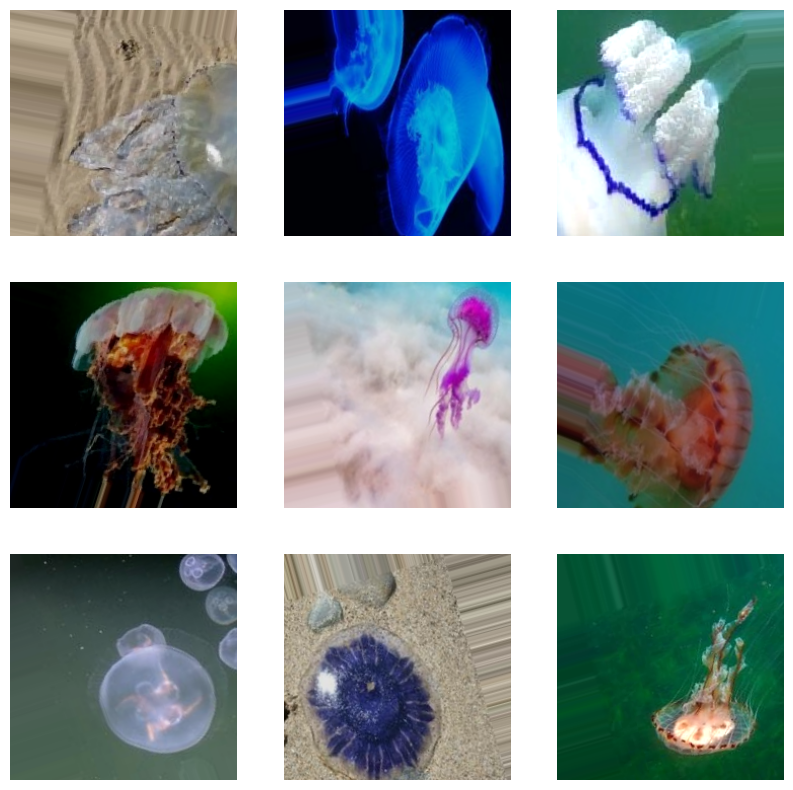

In [ ]:
# แสดงตัวอย่าง 9 ภาพจาก training set
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [ ]:
# สร้างโมเดล CNN
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))  # เพิ่ม Dropout layer เพื่อลด overfitting
model.add(layers.Dense(6))      # มีทั้งหมด 6 คลาส

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,768,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,825,670 (10.78 MB)

 Trainable params: 2,825,670 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 289s 8s/step - accuracy: 0.2092 - loss: 1.8771 - val_accuracy: 0.3750 - val_loss: 1.4717
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.3710 - loss: 1.5549 - val_accuracy: 0.4750 - val_loss: 1.3999
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.3865 - loss: 1.4992 - val_accuracy: 0.5250 - val_loss: 1.1631
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.4289 - loss: 1.4313 - val_accuracy: 0.5750 - val_loss: 1.1740
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.4431 - loss: 1.4121 - val_accuracy: 0.5750 - val_loss: 1.2090
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.4502 - loss: 1.3856 - val_accuracy: 0.5000 - val_loss: 1.1585
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.4737 - loss: 1.2825 - val_accuracy: 0.5750 - val_loss: 1.1931
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.4723 - loss: 1.3240 - val_accuracy: 0.5750 - val_loss: 1.

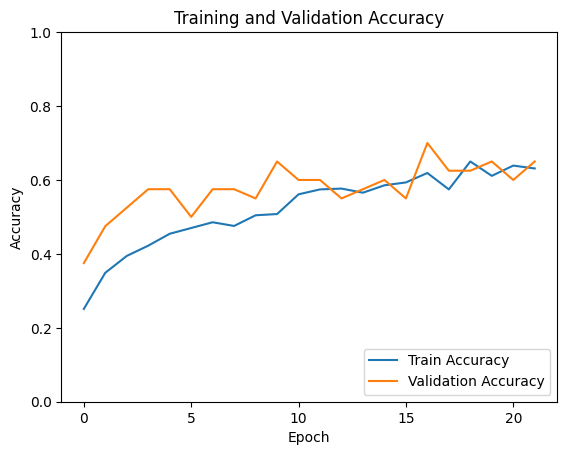

In [ ]:
# แสดงกราฟความแม่นยำ (Accuracy)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
# ประเมินโมเดลด้วยข้อมูลทดสอบ
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f'Test Accuracy: {test_acc:.4f}')

2/2 - 1s - 567ms/step - accuracy: 0.7000 - loss: 0.8465
Test Accuracy: 0.7000


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step


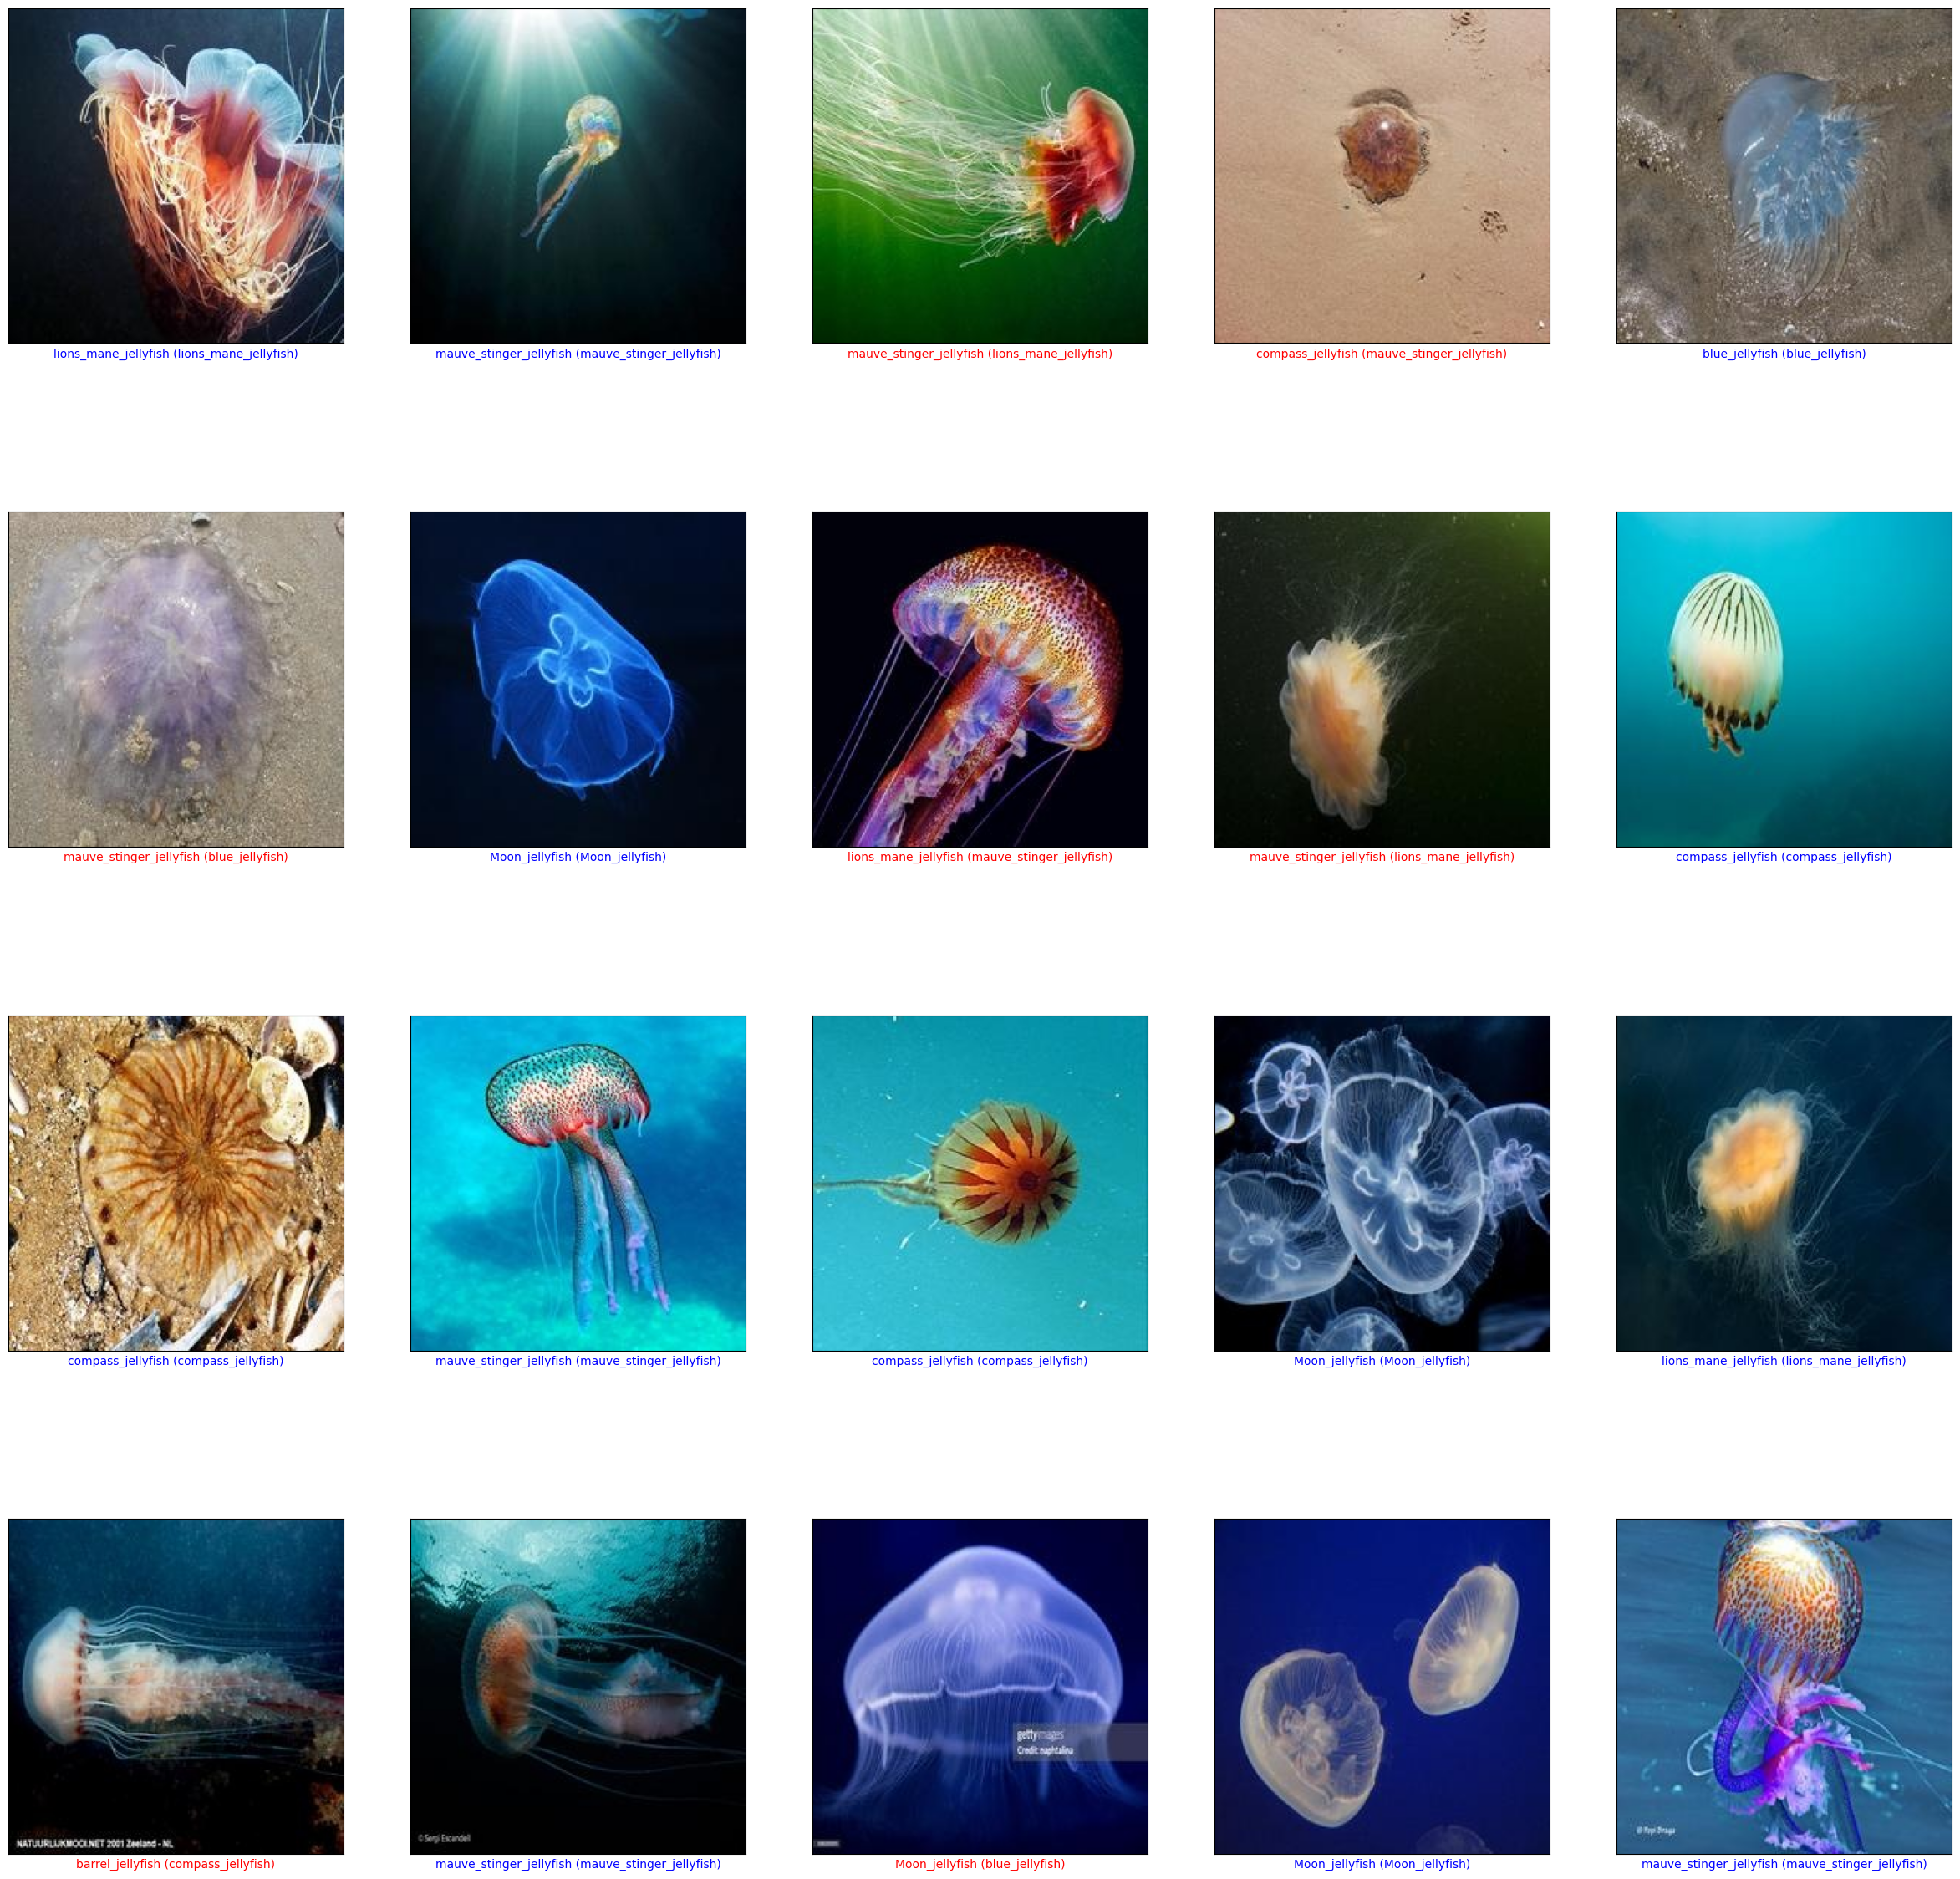

In [ ]:


# ดึงภาพและ labels จาก test_generator
test_images, test_labels = next(test_generator)

# ทำนายผลลัพธ์
predictions = model.predict(test_images)

# แปลง logits ให้เป็น label ที่โมเดลทำนาย
predicted_labels = np.argmax(predictions, axis=1)

# ดึง class_indices จาก train_generator เพื่อให้ได้ชื่อของคลาส
class_indices = train_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

# สุ่มเลือกภาพจำนวน 20 ภาพจากชุดทดสอบ
random_indices = np.random.choice(test_images.shape[0], 20, replace=False)
random_images = test_images[random_indices]
random_true_labels = test_labels[random_indices]
random_predicted_labels = predicted_labels[random_indices]

# แสดงผลภาพพร้อมคำทำนาย
plt.figure(figsize=(30, 30))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(random_images[i])

    # ดึงค่าชื่อคลาสจริงและที่โมเดลทำนาย
    true_label = random_true_labels[i]
    predicted_label = random_predicted_labels[i]

    # แสดงชื่อคลาสที่คาดการณ์และชื่อคลาสจริง
    color = 'blue' if predicted_label == true_label else 'red'
    plt.xlabel(f"{class_names[predicted_label]} ({class_names[true_label]})", color=color)
    # Class (Predicted)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


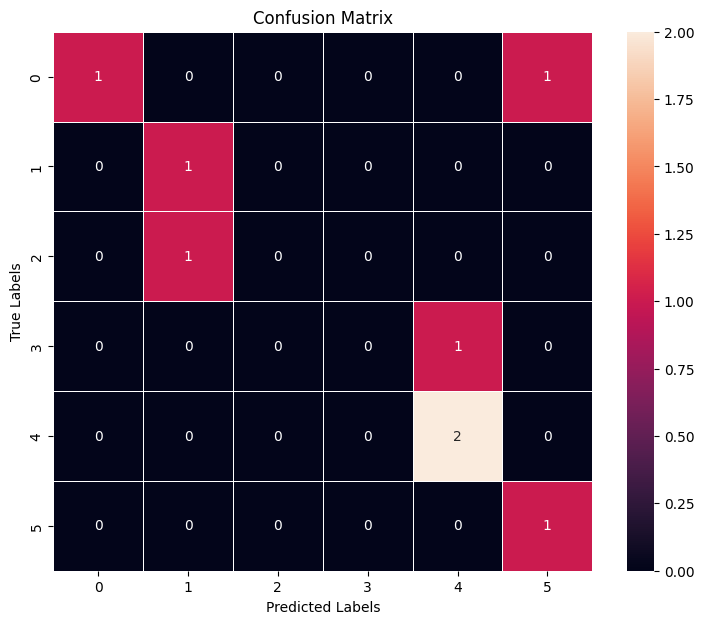

In [ ]:

# ดึงภาพและ labels จาก test_generator
test_images, test_labels = next(test_generator)

# ทำนายผลลัพธ์
predictions = model.predict(test_images)

# แปลง logits ให้เป็น label ที่โมเดลทำนาย
predicted_labels = np.argmax(predictions, axis=1)

# แปลง test_labels จาก one-hot encoded ให้เป็นรูปแบบ label ธรรมดา (ถ้า test_labels ยังเป็น one-hot)
# ในที่นี้คาดว่า test_labels มาจาก ImageDataGenerator ที่เป็นเลขอยู่แล้ว
true_labels = test_labels.astype(int)

# สร้าง Confusion Matrix
confusion_matrix = tf.math.confusion_matrix(true_labels, predicted_labels)

# แสดงผล Confusion Matrix ด้วย heatmap
f, ax = plt.subplots(figsize=(9, 7))
sn.heatmap(
    confusion_matrix,
    annot=True,        # แสดงตัวเลขในแต่ละช่อง
    linewidths=.5,     # ความหนาของเส้นแบ่ง
    fmt="d",           # แสดงตัวเลขเป็น integer
    square=True,       # ให้ heatmap เป็นสี่เหลี่ยมจัตุรัส
    ax=ax
)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()